In [1]:
# Comparision of cnn and ann model
# kaggle link https://www.kaggle.com/code/rohit1313/project-1-phase-3/notebook

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # using this we can make the image of normal folder refer to normal output label and similary for pneumonia folder
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pandas as pd

2024-03-15 02:37:40.644708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 02:37:40.644843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 02:37:40.799861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.15.0


In [3]:
train_data_path = '../input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [4]:
df

,filepaths,label
0,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
...,...,...
5211,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
5212,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
5213,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
5214,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL


In [5]:
valid_data_dir = '../input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [6]:
valid

,filepaths,label
0,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
5,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
6,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
7,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
8,../input/chest-xray-pneumonia/chest_xray/val/N...,NORMAL
9,../input/chest-xray-pneumonia/chest_xray/val/N...,NORMAL


In [7]:
test_data_dir = '../input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [8]:
test

,filepaths,label
0,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
...,...,...
619,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL
620,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL
621,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL
622,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL


In [9]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [10]:
# crobed image size
batch_size = 16 * strategy.num_replicas_in_sync
img_size = (180,180)

tr_gen = ImageDataGenerator(rescale = 1./255)
ts_gen = ImageDataGenerator(rescale = 1./255)
val_gen= ImageDataGenerator(rescale = 1./255)

train_dataset = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

val_dataset= val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_dataset = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


In [11]:
# Assuming 'train_dataset' is your dataset object

# Get the shape of the data
data_shape = train_dataset.image_shape
print("Shape of data:", data_shape)


Shape of data: (180, 180, 3)


In [12]:
# Assuming the class names are 'normal' and 'pneumonia'
class_indices = train_dataset.class_indices

# Count the number of examples for each class
num_normal_examples = sum(1 for label in train_dataset.labels if label == class_indices['NORMAL'])
num_pneumonia_examples = sum(1 for label in train_dataset.labels if label == class_indices['PNEUMONIA'])

print("Number of normal examples:", num_normal_examples)
print("Number of pneumonia examples:", num_pneumonia_examples)

Number of normal examples: 1050
Number of pneumonia examples: 3122


In [13]:
train_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters,(3,3), activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters,(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2,2))
    ]
    )
    
    return block

In [15]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
def build_model1():
    model1 = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(16,(3,3), activation='relu', padding='same',input_shape=(180,180, 3)),
        tf.keras.layers.Conv2D(16,(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D((2,2)),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(2, activation='sigmoid') # 2 neural unit not 1
    ])
    
    return model1

In [17]:
def build_model2():
    model2 = tf.keras.Sequential([        
        tf.keras.layers.Flatten(input_shape=(180,180,3)),
        dense_block(32,0.5), 
        dense_block(64,0.5),
        dense_block(64,0.5),
        dense_block(128,0.5),
        dense_block(128,0.5),
        dense_block(256,0.5),
        dense_block(256,0.5),
        dense_block(512,0.5),
        dense_block(512,0.5),
        dense_block(1024,0.5),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])
    
    return model2


In [18]:
weight_for_0 = (1 / num_normal_examples)*(num_normal_examples+num_pneumonia_examples)/2.0 
weight_for_1 = (1 / num_pneumonia_examples)*(num_normal_examples+num_pneumonia_examples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.99
Weight for class 1: 0.67


In [19]:
with strategy.scope():
    model1 = build_model1()
    model2 = build_model2()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='f1_score', threshold=0.5)
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint("xray_model1.keras",
                                                    save_best_only=True)
checkpoint_cb2 = tf.keras.callbacks.ModelCheckpoint("xray_model2.keras",
                                                    save_best_only=True)

In [21]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [22]:
EPOCHS =30 
history1 = model1.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[checkpoint_cb1, lr_scheduler],
    shuffle = False,
    verbose= 1
)
history2 = model2.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[checkpoint_cb2, lr_scheduler],
    shuffle = False,
    verbose= 1
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/261 ━━━━━━━━━━━━━━━━━━━━ 2:03:51 29s/step - accuracy: 0.5000 - f1_score: 0.5000 - loss: 0.6964 - precision: 0.5000 - recall: 0.3125

I0000 00:00:1710470313.036248     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710470313.067295     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6959 - f1_score: 0.6874 - loss: 0.6155 - precision: 0.6888 - recall: 0.6824

W0000 00:00:1710470391.659123     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710470393.660159     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710470403.458810     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 119s 349ms/step - accuracy: 0.6961 - f1_score: 0.6876 - loss: 0.6151 - precision: 0.6891 - recall: 0.6827 - val_accuracy: 0.7414 - val_f1_score: 0.7414 - val_loss: 2.6152 - val_precision: 0.7414 - val_recall: 0.7414 - learning_rate: 0.0100
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.8521 - f1_score: 0.8509 - loss: 0.3565 - precision: 0.8514 - recall: 0.8502 - val_accuracy: 0.5402 - val_f1_score: 0.5469 - val_loss: 0.7156 - val_precision: 0.5472 - val_recall: 0.5441 - learning_rate: 0.0089
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8909 - f1_score: 0.8905 - loss: 0.2842 - precision: 0.8907 - recall: 0.8901 - val_accuracy: 0.8927 - val_f1_score: 0.8918 - val_loss: 0.4293 - val_precision: 0.8880 - val_recall: 0.8966 - learning_rate: 0.0079
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.9198 - f1_score: 0.9190 - loss: 0.2111 - precision: 0.9187 - recall: 0.9194 - val_accuracy: 0.7759 - val

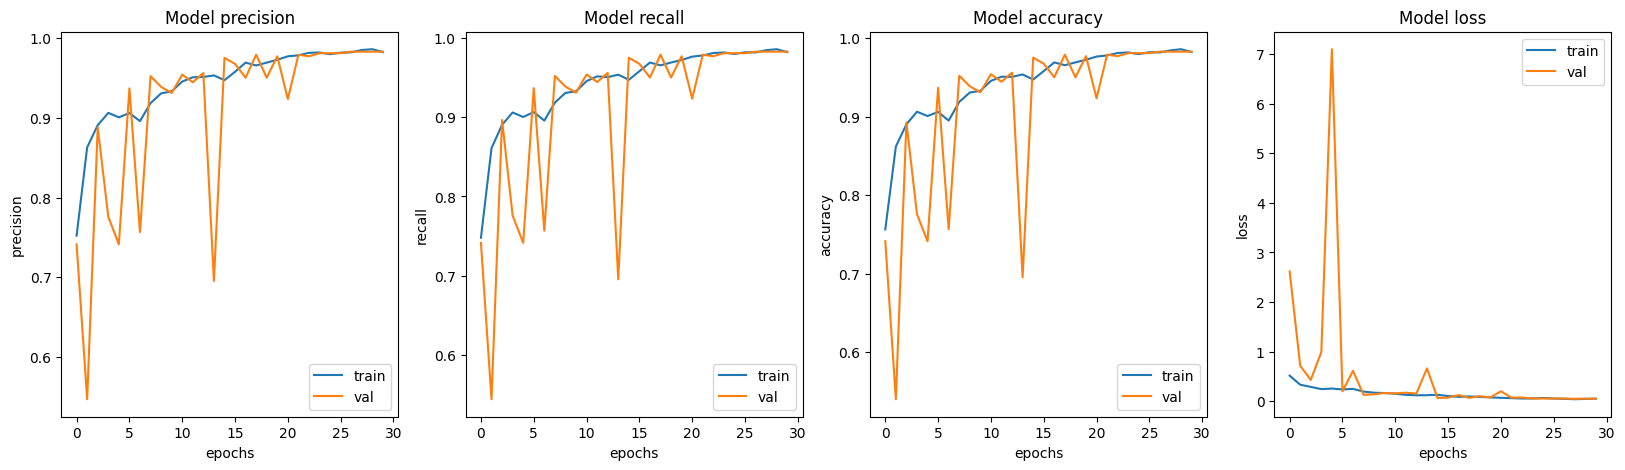

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

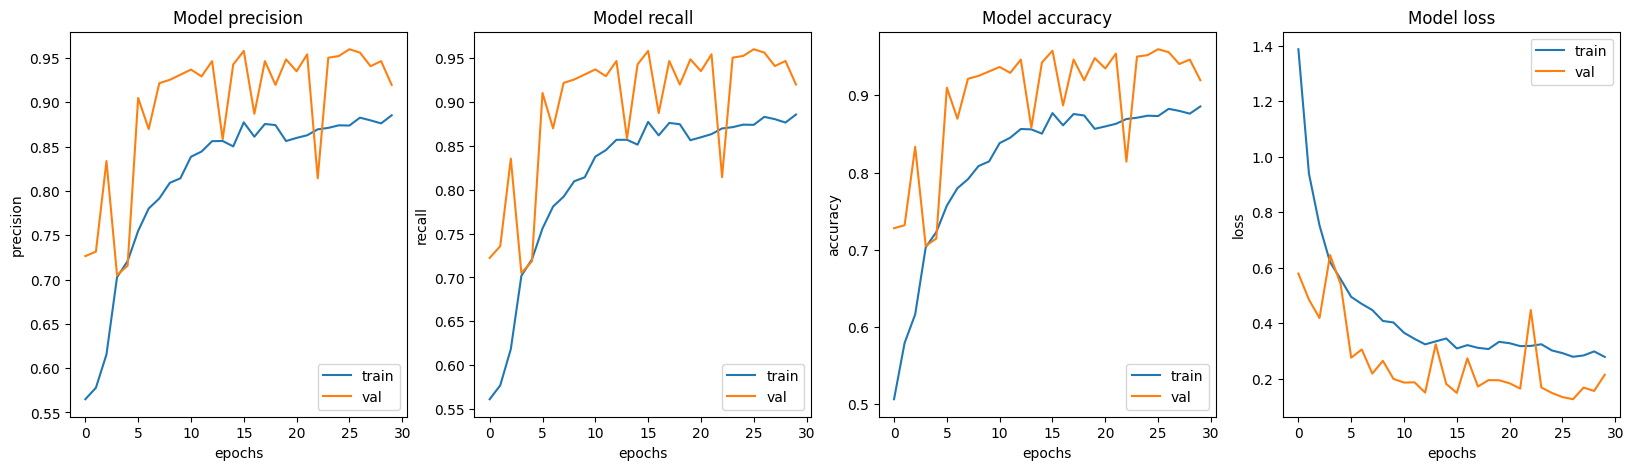

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, acc, prec, rec, f1 = model1.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.9723 - f1_score: 0.9723 - loss: 0.0476 - precision: 0.9723 - recall: 0.9723


In [26]:
loss, acc, prec, rec, f1 = model2.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.8879 - f1_score: 0.8879 - loss: 0.2709 - precision: 0.8879 - recall: 0.8879


In [27]:
# Load the model saved by ModelCheckpoint
checkpoint_model1 = tf.keras.models.load_model("xray_model1.keras")

# Evaluate the checkpoint model
loss, acc, prec, rec, f1= checkpoint_model1.evaluate(test_dataset)


 3/33 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9931 - f1_score: 0.9931 - loss: 0.0302 - precision: 0.9931 - recall: 0.9931

W0000 00:00:1710472814.238469     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9812 - f1_score: 0.9812 - loss: 0.0440 - precision: 0.9812 - recall: 0.9812


W0000 00:00:1710472819.325245     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [28]:
# Load the model saved by ModelCheckpoint
checkpoint_model2 = tf.keras.models.load_model("xray_model2.keras")

# Evaluate the checkpoint model
loss, acc, prec, rec, f1= checkpoint_model2.evaluate(test_dataset)


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9504 - f1_score: 0.9504 - loss: 0.1368 - precision: 0.9504 - recall: 0.9504


Based on the evaluation metrics, Model 1 with CNN performs better with higher accuracy (98.12%) and F1 score (98.12%) compared to Model 2 with ANN (accuracy: 95.04%, F1 score: 95.04%). Therefore, Model 1 (CNN) should be preferred for classifying X-ray images for pneumonia detection